In [23]:
from pyspark.sql import SparkSession 
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-11"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "\\bin;" + os.environ["PATH"]
os.environ["PYSPARK_PYTHON"] = r"C:\Users\kamal\AppData\Local\Programs\Python\Python310\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\kamal\AppData\Local\Programs\Python\Python310\python.exe"
os.environ["HADOOP_HOME"] = r"C:\\hadoop"
os.environ["PATH"] = os.environ["HADOOP_HOME"] + r"\bin;" + os.environ["PATH"]
spark = SparkSession.builder.appName("Spark_Project").config("spark.sql.shuffle.partitions", "8").config("spark.executor.memory", "8g").getOrCreate()
df = spark.read.csv(r'C:\Users\kamal\OneDrive\Desktop\Anti-Spam\data\DataSet_Emails\DataSet_Emails.csv',header=True,inferSchema=True , multiLine=True , escape='"')

In [24]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



In [25]:
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|summary|              _c0|        message_id|                text|             label|label_text|             subject|             message|
+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|  count|            31716|             31716|               31665|             31716|     31716|               31442|               31371|
|   mean|          15857.5|16854.187539412284|                NULL|0.5096165973010468|      NULL|            386429.0|            71403.25|
| stddev|9155.764905238666| 9734.616391716854|                NULL|0.4999153936875302|      NULL|  481877.22667086066|   136659.2035841348|
|    min|                0|                 0| ( b  $ b ! zck...|                 0|       ham|                ( b| & who wants to ...|
|    max|           

In [26]:
df.show(5)

+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|    0|       ham|enron / hpl actua...|teco tap 30 . 000...|2000-12-12|
|  4|     15880|looking for cheap...|    1|      spam|looking for cheap...|water past also ,...|2005-02-13|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
only showing top 5 rows


In [27]:
df = df.select('label' , 'text')


In [28]:
df = df.dropDuplicates()


In [29]:
from pyspark.sql.functions import col, sum

missing_data = df.filter(" OR ".join([f"{c} IS NULL" for c in df.columns]))
null_counts = missing_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in missing_data.columns])
null_counts.show()


+-----+----+
|label|text|
+-----+----+
|    0|   1|
+-----+----+



In [30]:
df_clean = df.dropna()

In [31]:
df_clean.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|13829|
|    0|14982|
+-----+-----+



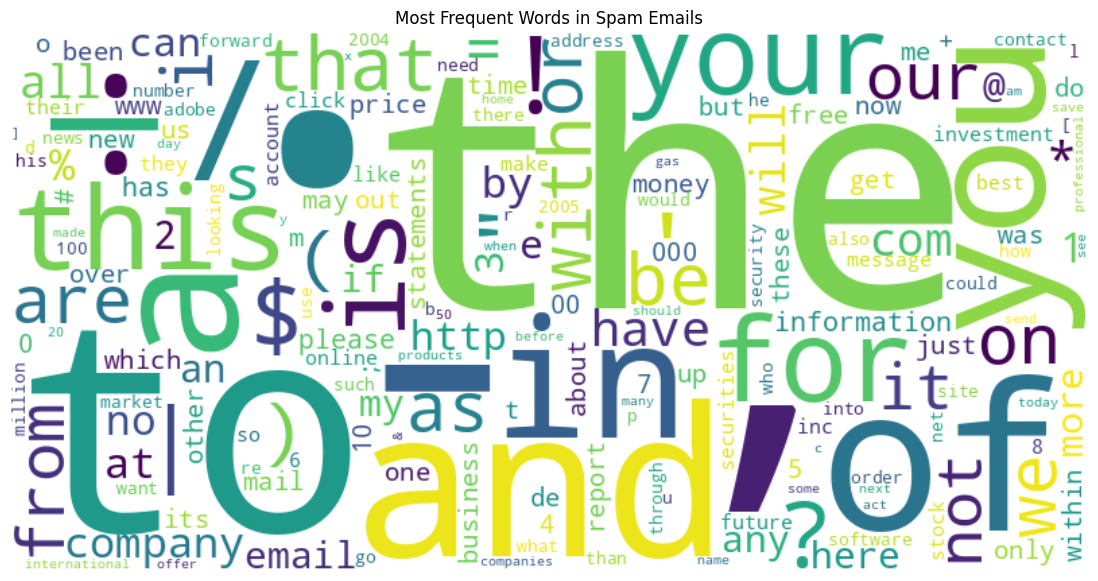

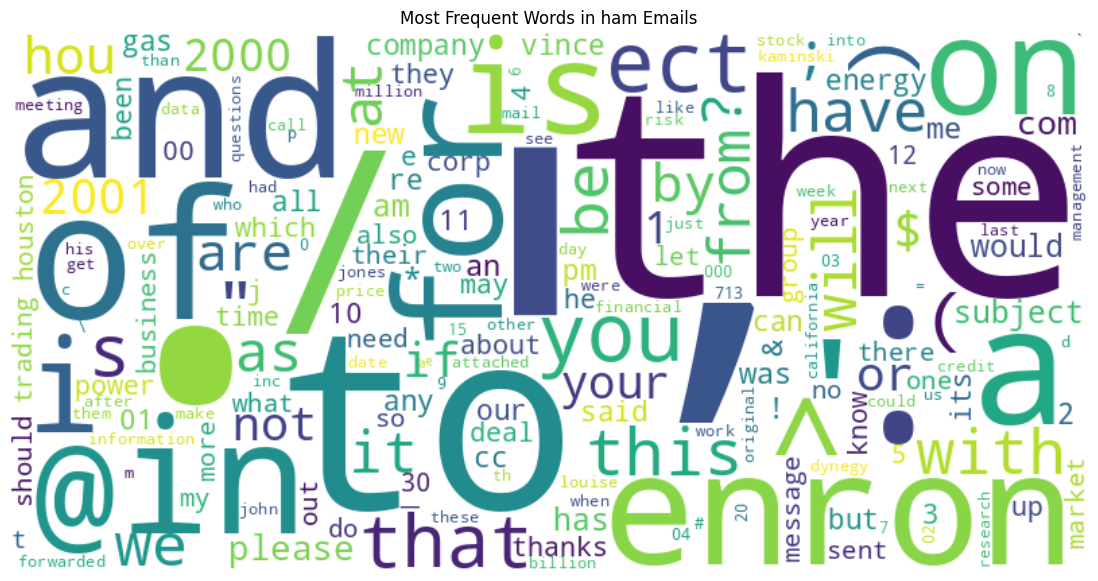

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode, split, lower

spam_df = df_clean.filter(col('label') == 1)
ham_df = df_clean.filter(col('label') == 0)

def create_wordcloud(title , df):
    words_df = df.select(explode(split(lower(col('text')), r'\s+')).alias('word'))
    
    word_freq = words_df.groupBy('word').count()

    top_words = word_freq.orderBy(col('count').desc()).limit(1000).collect()

    freq_dict = {row['word']: row['count'] for row in top_words}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud("Most Frequent Words in Spam Emails" , spam_df)
create_wordcloud("Most Frequent Words in ham Emails" , ham_df)



In [33]:
df_lower = (
    df_clean.withColumn("text", lower(col("text")))
)
df_lower.show()

+-----+--------------------+
|label|                text|
+-----+--------------------+
|    0|tenaska darren ,\...|
|    1|rolex watches sta...|
|    0|fw : vince and ra...|
|    1|signups with your...|
|    1|failure notice hi...|
|    0|funding deal loui...|
|    0|re : statistician...|
|    1|considered unsoli...|
|    0|10 % off ! our gi...|
|    0|fw : final revise...|
|    0|rick jones ' addr...|
|    0|settlement i made...|
|    1|delivery status n...|
|    0|fw : screen shots...|
|    1|dowlnoadable 70 +...|
|    0|fwd : enjoy fall ...|
|    0|anniversary hi , ...|
|    0|start date : 1 / ...|
|    1|perfect logo char...|
|    1|office xp - $ 60 ...|
+-----+--------------------+
only showing top 20 rows


In [34]:
from pyspark.ml.feature import RegexTokenizer

regex_tokenizer = RegexTokenizer(
    inputCol="text",
    outputCol="tokens",
    pattern="\\W+"    
)

In [35]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="tokens_no_sw"
)

In [36]:
from StemmerTransformer import StemmerTransformer

stemmer_transform = StemmerTransformer(inputCol="tokens_no_sw", outputCol="stemmed_tokens")


In [37]:
from pyspark.ml.feature import HashingTF , IDF

hashingTF = HashingTF(
    inputCol="stemmed_tokens",
    outputCol="raw_features",
    numFeatures=20000
)

idf = IDF(
    inputCol="raw_features",
    outputCol="features"
)



In [38]:
train_df, test_df = df_lower.randomSplit([0.8, 0.2], seed=42)

In [39]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

preproc_stages = [regex_tokenizer, remover, stemmer_transform, hashingTF, idf]

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

In [40]:
from pyspark.ml import Pipeline


pipeline_lr = Pipeline(stages=preproc_stages + [lr])
pipeline_rf = Pipeline(stages=preproc_stages +[rf])

In [41]:
model_lr = pipeline_lr.fit(train_df)
model_rf = pipeline_rf.fit(train_df)


In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
def evaluate_model(model, test_df):
    preds = model.transform(test_df)
    acc = evaluator_acc.evaluate(preds)
    f1  = evaluator_f1.evaluate(preds)
    return acc, f1

acc_lr, f1_lr = evaluate_model(model_lr, test_df)
acc_rf, f1_rf = evaluate_model(model_rf, test_df)

print("LogisticReg  -> acc: {:.4f} | f1: {:.4f}".format(acc_lr, f1_lr))
print("RandomForest -> acc: {:.4f} | f1: {:.4f}".format(acc_rf, f1_rf))


LogisticReg  -> acc: 0.9793 | f1: 0.9793
RandomForest -> acc: 0.9439 | f1: 0.9439


In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


lr = pipeline_lr.getStages()[-1]

paramGrid_lr = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 0.3])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.maxIter, [20, 50])
    .build()
)

cv_lr = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_f1,
    numFolds=3,            
    parallelism=4          
)

cv_model_lr = cv_lr.fit(train_df)


In [44]:
rf = pipeline_rf.getStages()[-1]

paramGrid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 7])
    .build()
)

cv_rf = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_f1,
    numFolds=3,
    parallelism=4
)

cv_model_rf = cv_rf.fit(train_df)


In [45]:
acc_lr, f1_lr = evaluate_model(cv_model_lr, test_df)
acc_rf, f1_rf = evaluate_model(cv_model_rf, test_df)

print("LogisticReg (CV)  -> acc: {:.4f} | f1: {:.4f}".format(acc_lr, f1_lr))
print("RandomForest (CV) -> acc: {:.4f} | f1: {:.4f}".format(acc_rf, f1_rf))


LogisticReg (CV)  -> acc: 0.9808 | f1: 0.9808
RandomForest (CV) -> acc: 0.9417 | f1: 0.9417


In [46]:
print("Best Logistic Regression Params:")
best_lr = cv_model_lr.bestModel.stages[-1]
print(best_lr._java_obj.parent().extractParamMap())


Best Logistic Regression Params:
{
	LogisticRegression_baff071488ac-aggregationDepth: 2,
	LogisticRegression_baff071488ac-elasticNetParam: 0.0,
	LogisticRegression_baff071488ac-family: auto,
	LogisticRegression_baff071488ac-featuresCol: features,
	LogisticRegression_baff071488ac-fitIntercept: true,
	LogisticRegression_baff071488ac-labelCol: label,
	LogisticRegression_baff071488ac-maxBlockSizeInMB: 0.0,
	LogisticRegression_baff071488ac-maxIter: 50,
	LogisticRegression_baff071488ac-predictionCol: prediction,
	LogisticRegression_baff071488ac-probabilityCol: probability,
	LogisticRegression_baff071488ac-rawPredictionCol: rawPrediction,
	LogisticRegression_baff071488ac-regParam: 0.01,
	LogisticRegression_baff071488ac-standardization: true,
	LogisticRegression_baff071488ac-threshold: 0.5,
	LogisticRegression_baff071488ac-tol: 1.0E-6
}


In [ ]:
print("Best Random Forest Params:")
best_rf = cv_model_rf.bestModel.stages[-1]
print(best_rf._java_obj.parent().extractParamMap())


Best Random Forest Params:
{
	RandomForestClassifier_ed3947432c66-bootstrap: true,
	RandomForestClassifier_ed3947432c66-cacheNodeIds: false,
	RandomForestClassifier_ed3947432c66-checkpointInterval: 10,
	RandomForestClassifier_ed3947432c66-featureSubsetStrategy: auto,
	RandomForestClassifier_ed3947432c66-featuresCol: features,
	RandomForestClassifier_ed3947432c66-impurity: gini,
	RandomForestClassifier_ed3947432c66-labelCol: label,
	RandomForestClassifier_ed3947432c66-leafCol: ,
	RandomForestClassifier_ed3947432c66-maxBins: 32,
	RandomForestClassifier_ed3947432c66-maxDepth: 7,
	RandomForestClassifier_ed3947432c66-maxMemoryInMB: 256,
	RandomForestClassifier_ed3947432c66-minInfoGain: 0.0,
	RandomForestClassifier_ed3947432c66-minInstancesPerNode: 1,
	RandomForestClassifier_ed3947432c66-minWeightFractionPerNode: 0.0,
	RandomForestClassifier_ed3947432c66-numTrees: 100,
	RandomForestClassifier_ed3947432c66-predictionCol: prediction,
	RandomForestClassifier_ed3947432c66-probabilityCol: probabi

In [48]:
best_model = cv_model_lr.bestModel
best_model.write().overwrite().save("models/best_lr_pipeline")
